# Домашнее задание №1. Softmax Regression.

Нужно реализовать много-классовую логистическую регрессию с помощью softmax c поддержкой L1/L2 регуляризации. После этого сравнить с sklearn реализацией [SGDClassifier(loss="log_loss")](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LearningCurveDisplay

### Constants

In [2]:
RANDOM_STATE = 42

WINE_DATA_PATH = '../data/raw/wine.csv'

FEATURE_TARGET = 'Wine'

## Задание №1 (10 баллов)

Реализовать класс SoftMaxRegression и его методы - init, fit, predict c возможностью конфигурации
регуляризации. 
Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**. 

Остальные функции реализовать на ваше усмотрение. 

In [22]:
class SoftMaxRegression:
    def __init__(self, 
                 penalty=None, 
                 learning_rate=0.1,
                 tol=1e-4,
                 alpha=0.0001,
                 fit_intercept=True,
                 max_iter=1000,
                 random_state=None,
                ):
        self.penalty=penalty
        self.learning_rate=learning_rate
        self.tol=tol
        self.alpha=alpha
        self.fit_intercept=fit_intercept
        self.max_iter=max_iter
        self.random_state=random_state

        self.intercept = 0
        self.theta = None
        self.shift = 0

    def logits(self, X):
        return X @ self.theta

    def softmax(self, logits):
        return np.exp(-logits) / np.sum(np.exp(-logits))

    def gradient(self, X, Y, preds):
        N = X.shape[0]
        return (1 / N) * (X.T @ (Y - preds))

    def gradient_l1(self):
        gradient = self.alpha * np.sign(self.theta)
        
        if self.fit_intercept:
            gradient[0] = 0
        return gradient

    def gradient_l2(self):
        gradient = 2 * self.alpha * self.theta

        if self.fit_intercept:
            gradient[0] = 0
        return 2 * self.alpha * self.theta

    def gradient_descent(self, X, Y):
        self.losses = []
        lr = self.learning_rate

        if self.penalty == 'l2':
            gradient_reg = self.gradient_l2
        elif self.penalty == 'l1':
            gradient_reg = self.gradient_l1
        else:
            gradient_reg = lambda: 0
        
        for step in range(self.max_iter):
            preds = self.__predict_proba_internal(X)
            delta = -lr * self.gradient(X, Y, preds) + gradient_reg()

            if np.all(np.abs(delta) <= self.tol):
                break

            self.theta += delta
    
    def fit(self, X, y):
        n, f = X.shape

        if type(X) is not np.ndarray:
            X = np.array(X)
        if type(y) is not np.ndarray:
            y = np.array(y)

        self.shift = y.min()
        y_train = y - self.shift if self.shift != 0 else y
        Y_train = pd.get_dummies(y_train).astype('float')
        c = Y_train.shape[1]
        Y_train.columns = range(c)
        
        if self.fit_intercept:
            self.theta = np.zeros((f + 1, c))
            X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        else:
            self.theta = np.zeros((f, c))
            X_train = X

        self.gradient_descent(X_train, Y_train)

    def __predict_proba_internal(self, X):
        logits = self.logits(X)
        return np.apply_along_axis(self.softmax, 1, logits)
    
    def predict_proba(self, X):
        if self.fit_intercept:
            X_ = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
            return self.__predict_proba_internal(X_)
        else:
            return self.__predict_proba_internal(X)

    def __predict_internal(self, X):
        p = self.__predict_proba_internal(X)
        return np.argmax(p, axis=1) + self.shift
    
    def predict(self, X):
        p = self.predict_proba(X)
        return np.argmax(p, axis=1) + self.shift

    def get_params(self, deep=False):
        return {
            'penalty': self.penalty,
            'learning_rate': self.learning_rate,
            'tol': self.tol,
            'alpha': self.alpha,
            'fit_intercept': self.fit_intercept,
            'max_iter': self.max_iter,
            'random_state': self.random_state,
        }

## Задание №2 (10 баллов)

Загрузите любой датасет много-классовой классификации, сделайте предобработку, разбейте на тренировочную и тестовую выборку  и оцените работу вашего алгоритма. Предпочтительно использовать метрику точности(accuracy) для оценки алгоритма. 

В рамках оценки, воспользуйтесь sklearn реализацией много-классовой логистической регрессии. **Проверьте что ваши метрики совпадают(+/-1-2%) на моделях без регуляризации, с L1 и с L2 регуляризации.**

#### Работа с датасетом (1 балл)

Загрузите выбранный датасет много-классовой классификации, обработайте его, сделайте разбиение на тренировочную и тестовую выборку. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table).

### Read

In [4]:
def read_data(path):
    return pd.read_csv(path)

In [5]:
df = read_data(WINE_DATA_PATH)
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wine                  178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic.acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Acl                   178 non-null    float64
 5   Mg                    178 non-null    int64  
 6   Phenols               178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid.phenols  178 non-null    float64
 9   Proanth               178 non-null    float64
 10  Color.int             178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD                    178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


### Clean

Не требуется

### Missing Values

Не требуется

### Encode

Не требуется

### Feature Utility Scores and Drop Uninformative

In [7]:
def make_mi_scores(X, y, random_state=0):
    X = X.copy()
    for feature in X.select_dtypes(['object', 'category', 'datetime64[ns]']):
        X[feature], _ = X[feature].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')

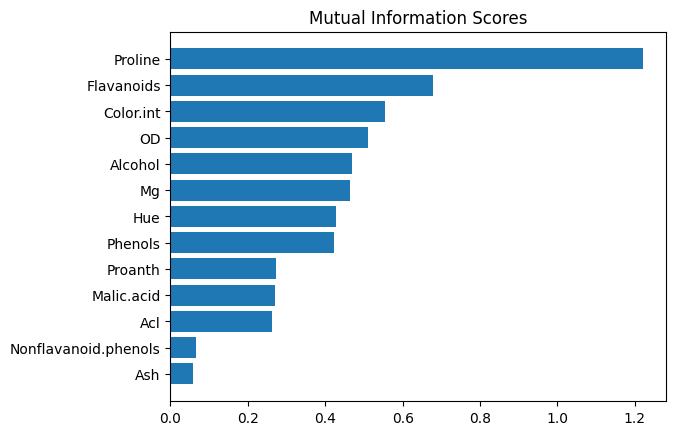

In [9]:
X = df.copy()
y = X.pop(FEATURE_TARGET)

mi_scores = make_mi_scores(X, y, random_state=RANDOM_STATE)
plot_mi_scores(mi_scores)

### Preprocessing Pipeline

In [10]:
def get_preprocessor(df, random_state=None):
    features_num = list(df.select_dtypes(('int64', 'float64')).columns)
    
    num_transformer = Pipeline([
        ('scaler', StandardScaler()),
        ('transformer', QuantileTransformer(n_quantiles=100, random_state=random_state)),
    ])

    preprocessor = ColumnTransformer([
        ('num', num_transformer, features_num),
    ])
    return preprocessor

In [11]:
preprocessor = get_preprocessor(X)

In [12]:
X = pd.DataFrame(preprocessor.fit_transform(X))
X.columns = preprocessor.get_feature_names_out()

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num__Alcohol               178 non-null    float64
 1   num__Malic.acid            178 non-null    float64
 2   num__Ash                   178 non-null    float64
 3   num__Acl                   178 non-null    float64
 4   num__Mg                    178 non-null    float64
 5   num__Phenols               178 non-null    float64
 6   num__Flavanoids            178 non-null    float64
 7   num__Nonflavanoid.phenols  178 non-null    float64
 8   num__Proanth               178 non-null    float64
 9   num__Color.int             178 non-null    float64
 10  num__Hue                   178 non-null    float64
 11  num__OD                    178 non-null    float64
 12  num__Proline               178 non-null    float64
dtypes: float64(13)
memory usage: 18.2 KB


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(124, 13) (54, 13) (124,) (54,)


#### Обучение модели и сравнение с sklearn имплементацией

Обучите 3 модели - обычную, с L1 реализацией, с L2 реализацией и сравните с аналогичной sklearn имплементацией много-классовой логистической регрессии. 

В рамках обучения модели требуется визуализировать:

1) График падания значений ошибки на тренировочной выборке в зависимости от итерации.
2) График падания значений ошибки на валидационной выборке в зависимости от итерации.
3) График роста метрики точности в зависимости от итерации.

<span style="color:red">**Модель считается успешно реализованной, если целевая метрика совпадает с sklearn [реализацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)   c log_loss функцией ошибки. 
    
Если разница большая(более 2%), баллы за ДЗ не проставляются.**</span>

Ваши гиперпараметры должны совпадать с параметрами, которые вы указываете в sklearn версии.

In [15]:
def plot_learning_curves(models, X, y, random_state=None):
    fig, ax = plt.subplots(nrows=1, ncols=len(models), figsize=(12, 6), sharey=True)

    for ax_idx, estimator in enumerate(models):
        LearningCurveDisplay.from_estimator(estimator, X, y, scoring='accuracy', ax=ax[ax_idx], random_state=random_state)
        handles, label = ax[ax_idx].get_legend_handles_labels()
        ax[ax_idx].legend(handles[:2], ['Training Score', 'Validation Score'])
        ax[ax_idx].set_title(f'Accuracy for {estimator.__class__.__name__}')

#### Обучение обычной модели и сравнение с __SGDClassifier(loss="log_loss", penalty = 'none')__ (3 балла)

In [16]:
my_clf_penalty_none = SoftMaxRegression(penalty=None, max_iter=1000, random_state=RANDOM_STATE)
sklearn_clf_penalty_none = SGDClassifier(loss='log_loss', penalty=None, max_iter=1000, random_state=RANDOM_STATE)

my_clf_penalty_none_cv = cross_val_score(my_clf_penalty_none, X_train, y_train, cv=5, scoring='accuracy')
sklearn_clf_penalty_none_cv = cross_val_score(sklearn_clf_penalty_none, X_train, y_train, cv=5, scoring='accuracy')

print(f'Accuracy of my model: {my_clf_penalty_none_cv.mean():.4f}')
print(f'Accuracy of sklearn model: {sklearn_clf_penalty_none_cv.mean():.4f}')

Accuracy of my model: 0.9757
Accuracy of sklearn model: 0.9673


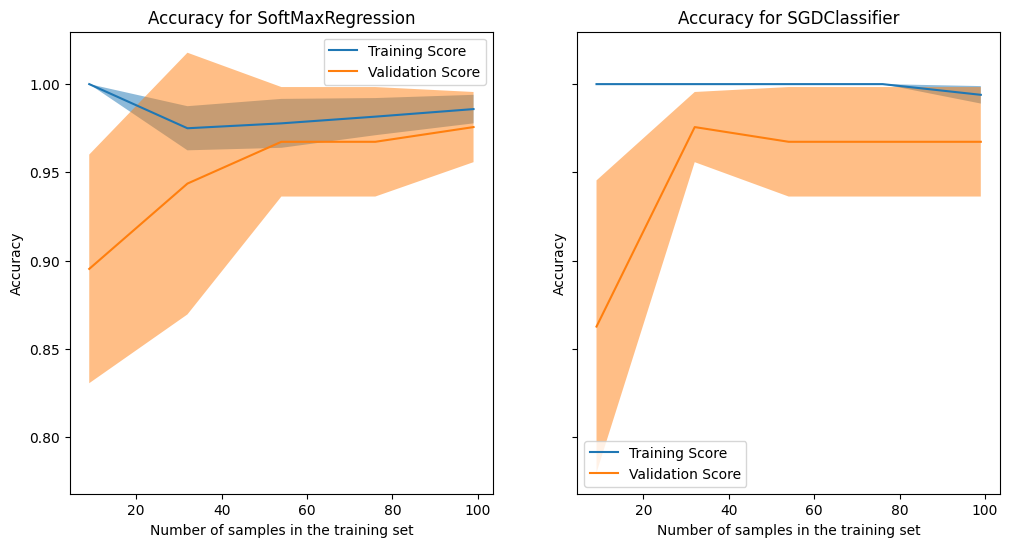

In [17]:
my_clf_penalty_none = SoftMaxRegression(penalty=None, max_iter=1000, random_state=RANDOM_STATE)
sklearn_clf_penalty_none = SGDClassifier(loss='log_loss', penalty=None, max_iter=1000, random_state=RANDOM_STATE)

plot_learning_curves([my_clf_penalty_none, sklearn_clf_penalty_none], X_train, y_train)

#### Обучение модели c L1 регуляризацией и сравнение с __SGDClassifier(loss="log_loss", penalty = 'l1')__ (3 балла)

In [18]:
my_clf_penalty_l1 = SoftMaxRegression(penalty='l1', max_iter=1000, random_state=RANDOM_STATE)
sklearn_clf_penalty_l1 = SGDClassifier(loss='log_loss', penalty='l1', max_iter=1000, random_state=RANDOM_STATE)

my_clf_penalty_l1_cv = cross_val_score(my_clf_penalty_l1, X_train, y_train, cv=5, scoring='accuracy')
sklearn_clf_penalty_l1_cv = cross_val_score(sklearn_clf_penalty_l1, X_train, y_train, cv=5, scoring='accuracy')

print(f'Accuracy of my model: {my_clf_penalty_l1_cv.mean():.4f}')
print(f'Accuracy of sklearn model: {sklearn_clf_penalty_l1_cv.mean():.4f}')

Accuracy of my model: 0.9757
Accuracy of sklearn model: 0.9673


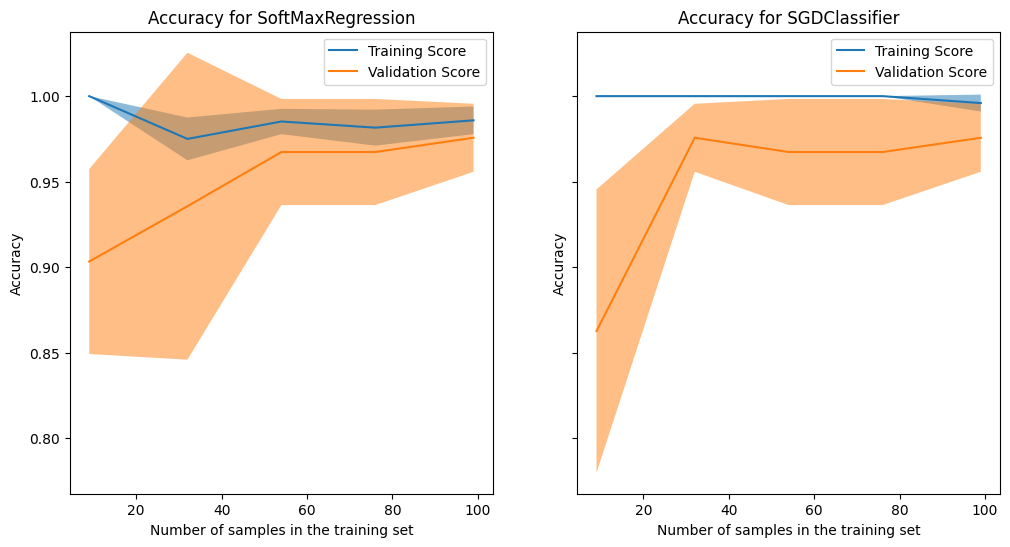

In [19]:
my_clf_penalty_l1 = SoftMaxRegression(penalty='l1', max_iter=1000, random_state=RANDOM_STATE)
sklearn_clf_penalty_l1 = SGDClassifier(loss='log_loss', penalty='l1', max_iter=1000, random_state=RANDOM_STATE)

plot_learning_curves([my_clf_penalty_l1, sklearn_clf_penalty_l1], X_train, y_train)

#### Обучение модели c L2 регуляризацией и сравнение с __SGDClassifier(loss="log_loss", penalty = 'l2')__ (3 балла)

In [23]:
my_clf_penalty_l2 = SoftMaxRegression(penalty='l2', max_iter=1000, random_state=RANDOM_STATE)
sklearn_clf_penalty_l2 = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=RANDOM_STATE)

my_clf_penalty_l2_cv = cross_val_score(my_clf_penalty_l2, X_train, y_train, cv=5, scoring='accuracy')
sklearn_clf_penalty_l2_cv = cross_val_score(sklearn_clf_penalty_l2, X_train, y_train, cv=5, scoring='accuracy')

print(f'Accuracy of my model: {my_clf_penalty_l2_cv.mean():.4f}')
print(f'Accuracy of sklearn model: {sklearn_clf_penalty_l2_cv.mean():.4f}')

Accuracy of my model: 0.9757
Accuracy of sklearn model: 0.9673


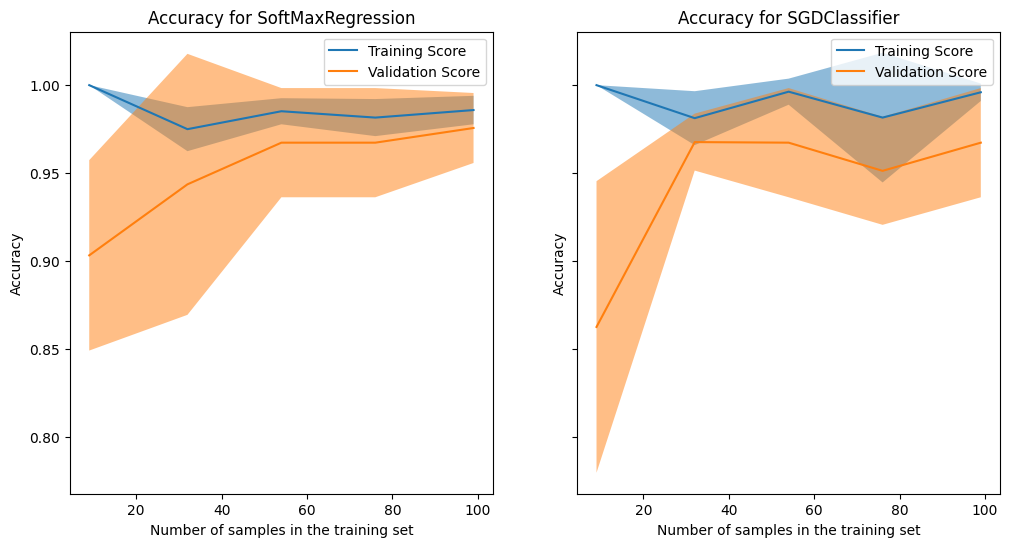

In [24]:
my_clf_penalty_none = SoftMaxRegression(penalty='l2', max_iter=1000, random_state=RANDOM_STATE)
sklearn_clf_penalty_none = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=RANDOM_STATE)

plot_learning_curves([my_clf_penalty_l2, sklearn_clf_penalty_l2], X_train, y_train)